# ITS

### Импорт всех необходимых библиотек

In [ ]:
import numpy as np
import base64
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, GlobalAveragePooling2D, MaxPool2D, Dropout, Flatten, AveragePooling2D
from tensorflow.keras.models import Sequential
import PIL.ImageDraw as ImageDraw
import PIL.Image as Image
from sklearn.preprocessing import StandardScaler
import os

W = 640
H = 512

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Задача сегментации

### Создание масок для обучения

In [ ]:
files = os.listdir('/content/drive/My Drive/test/test/')
print(len(files))
files[:5]

107


['002.png', '017.png', '016.png', '003.png', '029.png']

In [ ]:
for i in files:
    print(i[:3], '...', sep = '',end=' ')
    image = Image.open('/content/drive/My Drive/test/test/'+i).convert('L')
    image.save('/content/drive/My Drive/test/test/'+i)
    print('Done!')

### Создание генераторов для задачи сегментации

In [ ]:
aug = ImageDataGenerator(
    rescale=1/255,
    horizontal_flip=True,
    vertical_flip=True
)
X_train = aug.flow_from_directory(
    directory='/content/drive/My Drive/train/',
    class_mode='binary',
    color_mode = 'grayscale',
    batch_size = 261,
    target_size=(H, W),
    seed=50
)

y_train = aug.flow_from_directory(
    directory='/content/drive/My Drive/train_mask/',
    class_mode='binary',
    color_mode = 'grayscale',
    batch_size = 261,
    target_size=(H, W),
    seed=50
)

Found 261 images belonging to 1 classes.
Found 261 images belonging to 1 classes.


### Выгрузка изображений в оперативную память

In [ ]:
for i in range(3):
    print(i,'...', sep = '', end=' ')
    if i==0:
        X = X_train.next()[0]
        y = y_train.next()[0]
    else:
        X = np.append(X, X_train.next()[0], axis = 0)
        y = np.append(y, y_train.next()[0], axis = 0)
    print('Complete')
    print(X.shape)

0... Complete
(261, 512, 640, 1)
1... Complete
(522, 512, 640, 1)
2... Complete
(783, 512, 640, 1)


### Проверка на соответствие масок изображениям

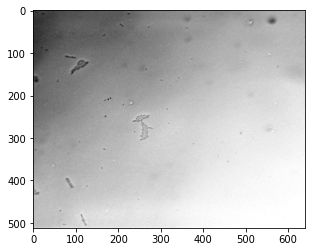

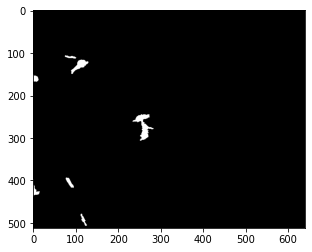

In [ ]:
plt.imshow(X[50][:,:,0], cmap='gray')
plt.show()
plt.imshow(y[50][:,:,0], cmap='gray')
plt.show()

### Распределение значений на изображении

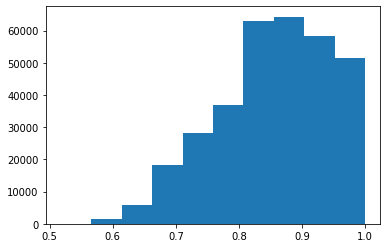

In [ ]:
plt.hist(X[0].flatten())
plt.show()

### Нормализируем входные данные
С помощью библиотеки `sklearn`

In [ ]:
X = X[:, :, :, 0]
for i, item in enumerate(X):
    X[i] = StandardScaler().fit_transform(item)
X = X[:, :, :, None]

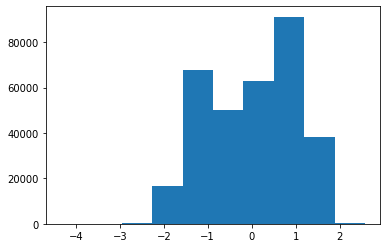

In [ ]:
plt.hist(X[0].flatten())
plt.show()

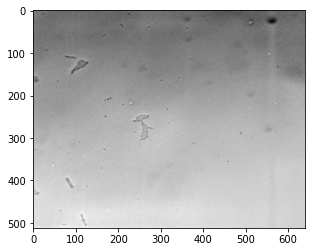

In [ ]:
plt.imshow(X[50][:, :, 0], cmap='gray')
plt.show()

### Создание модели

In [ ]:
def build_model():
    x = tf.keras.layers.Input((H, W, 1))

    out = Conv2D(32, (3, 3), padding='same', activation = 'relu')(x)
    out1 = Conv2D(32, (3, 3), padding='same', activation = 'relu')(out)

    out = Conv2D(64, (3, 3), padding='same', strides=(2, 2), activation = 'relu')(out1)
    out2 = Conv2D(64, (3, 3), padding='same', activation = 'relu')(out)
    
    out = Conv2D(128, (3, 3), padding='same', strides=(2, 2), activation = 'relu')(out2)
    out3 = Conv2D(128, (3, 3), padding = 'same', activation = 'relu')(out)

    out = Conv2D(256, (3, 3), padding='same', strides=(2, 2), activation = 'relu')(out3)
    out = Conv2D(256, (3, 3), padding = 'same', activation = 'relu')(out)

    out = Conv2DTranspose(128, (3, 3), padding='same', strides=(2, 2), activation = 'relu')(out)
    out = tf.concat([out, out3], axis = 3)
    out = Conv2D(128, (3, 3), padding='same', activation = 'relu')(out)

    out = Conv2DTranspose(64, (3, 3), padding='same', strides=(2, 2), activation = 'relu')(out)
    out = tf.concat([out, out2], axis = 3)
    out = Conv2D(64, (3, 3), padding='same', activation = 'relu')(out)

    out = Conv2DTranspose(32, (3, 3), padding='same', strides=(2, 2), activation = 'relu')(out)
    out = tf.concat([out, out1], axis = 3)
    out = Conv2D(32, (3, 3), padding='same', activation='relu')(out)

    out = Conv2D(1, (1, 1), padding='same', activation='sigmoid')(out)
    
    return tf.keras.Model(inputs=x, outputs=out)
model = build_model()

In [ ]:
NUM_EPOCHS = 15
BATCH_SIZE = 1

loss = tf.keras.losses.BinaryCrossentropy()
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
model.compile(optimizer='adam', loss = loss, metrics = [precision, recall, 'accuracy'])

hist = model.fit(X, y, batch_size=BATCH_SIZE,
                 epochs=NUM_EPOCHS,
                 validation_split=0.2)

### Отрисовка статистики результатов обучения

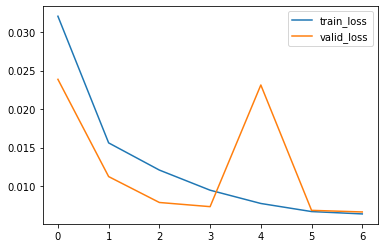

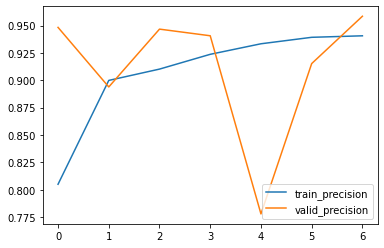

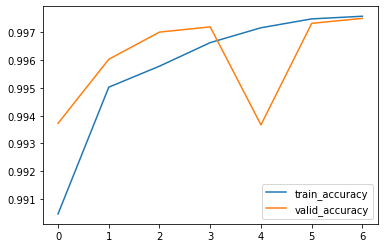

In [ ]:
plt.plot(hist.history['loss'], label='train_loss')
plt.plot(hist.history['val_loss'], label='valid_loss')
plt.legend()
plt.show()
plt.plot(hist.history['precision_1'], label='train_precision')
plt.plot(hist.history['val_precision_1'], label='valid_precision')
plt.legend()
plt.show()
plt.plot(hist.history['accuracy'], label='train_accuracy')
plt.plot(hist.history['val_accuracy'], label='valid_accuracy')
plt.legend()
plt.show()

In [ ]:
hist += model.fit(X, y, batch_size=BATCH_SIZE,
                 epochs=1,
                 validation_split=0.2)

In [ ]:
hist = model.fit(X, y, batch_size=1,
                 epochs=3,
                 validation_split=0.2)

Epoch 1/3
626/626 [==============================] - 53s 85ms/step - loss: 0.0037 - precision_1: 0.9593 - recall_1: 0.9549 - accuracy: 0.9985 - val_loss: 0.0060 - val_precision_1: 0.9580 - val_recall_1: 0.9346 - val_accuracy: 0.9980
Epoch 2/3
626/626 [==============================] - 52s 83ms/step - loss: 0.0034 - precision_1: 0.9614 - recall_1: 0.9580 - accuracy: 0.9985 - val_loss: 0.0055 - val_precision_1: 0.9550 - val_recall_1: 0.9439 - val_accuracy: 0.9981
Epoch 3/3
626/626 [==============================] - 52s 84ms/step - loss: 0.0051 - precision_1: 0.9526 - recall_1: 0.9430 - accuracy: 0.9981 - val_loss: 0.0079 - val_precision_1: 0.9423 - val_recall_1: 0.9066 - val_accuracy: 0.9972


In [ ]:
model.save('/content/drive/My Drive/best_model15.h5')

## Задача классификации

### Разделение исходных данных по классам

In [ ]:
files = os.listdir('/content/drive/My Drive/train/train/')
files = np.sort([i for i in files if '.json' in i])
train_size = len(files)
files[:5]

array(['001.json', '002.json', '003.json', '004.json', '005.json'],
      dtype='<U8')

In [ ]:
path = '/content/drive/My Drive/'
os.mkdir(path + 'train_classific')
for i in files:
    image = Image.open(path + 'train/train/' + i[:3] + '.png')
    data = pd.read_json(path + 'train/train/' + i)
    label = data.iloc[0]['shapes']['label']
    if not os.path.exists(path + 'train_classific/'+label+'/'):
      os.mkdir(path + 'train_classific/'+label+'/')
    image.save(path + 'train_classific/' + label + '/' + i[:3]+ '.png')

In [ ]:
path = '/content/drive/My Drive/'
for num, i in enumerate(files):
    print(num,'...', sep='', end = ' ')
    image = Image.open(path + 'train/train/' + i[:3] + '.png').convert('L')
    mask = Image.open(path + 'train_mask/train_mask/' + i[:3] + '.png').convert('L')
    
    image = np.array(image)
    mask = np.array(mask)
    image[image>mask] = 255

    data = pd.read_json(path + 'train/train/' + i)
    label = data.iloc[0]['shapes']['label']
    if not os.path.exists(path + 'classification/'+label+'/'):
      os.mkdir(path + 'classification/'+label+'/')
    Image.fromarray(image).save(path + 'classification/' + label + '/' + i[:3]+ '.png')
    print('Done!')

### Создание генераора для задачи классификации

In [ ]:
aug = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True
)

X_train = aug.flow_from_directory(
    directory='/content/drive/My Drive/dataset_its/train_classific',
    class_mode='categorical',
    color_mode = 'grayscale',
    batch_size = 261,
    target_size=(H, W),
    seed=50
)

Xhelper_train = aug.flow_from_directory(
    directory='/content/drive/My Drive/dataset_its/train_masks',
    class_mode='binary',
    color_mode = 'grayscale',
    batch_size = 261,
    target_size=(H, W),
    seed=50
)

Found 261 images belonging to 6 classes.
Found 261 images belonging to 1 classes.


### Выгрузка изображений в оперативную память

In [ ]:
X = []
Xhelper = []
y = []

for i in range(2):
    print(i,'...', sep = '', end=' ')
    train = X_train.next()
    helper_train = Xhelper_train.next()
    if i==0:
        X = train[0]
        y = train[1]
        Xhelper = helper_train[0]
    else:
        X = np.append(X, train[0], axis = 0)
        y = np.append(y, train[1], axis = 0)
        Xhelper = np.append(Xhelper, helper_train[0], axis = 0)
    print('Complete')
    print(X.shape)

0... Complete
(261, 512, 640, 1)
1... Complete
(522, 512, 640, 1)


In [ ]:
for i, item in enumerate(X):
    img = StandardScaler().fit_transform(item[:, :, 0])[:, :, None]
    X[i] = img

for i, item in enumerate(Xhelper):
    img = StandardScaler().fit_transform(item[:, :, 0])[:, :, None]
    Xhelper[i] = img
X.shape

(522, 512, 640, 1)

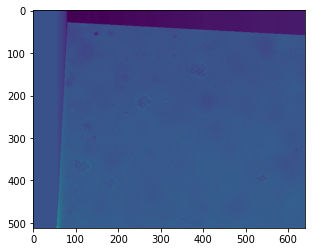

In [ ]:
plt.imshow(X[20,:,:,0])

### Создание модели

In [ ]:
def build_model():
    image = tf.keras.layers.Input((H, W, 1))
    image_out = Conv2D(32, (3, 3), padding='same', activation='relu')(image)
    image_out = Conv2D(32, (3, 3), padding='same', activation='relu')(image_out)
    image_out = MaxPool2D((2, 2))(image_out)
    image_out = Conv2D(64, (3, 3), padding='same', activation='relu')(image_out)
    image_out = Conv2D(64, (3, 3), padding='same', activation='relu')(image_out)
    image_out = MaxPool2D((2, 2))(image_out)
    image_out = Conv2D(128, (3, 3), padding='same', activation='relu')(image_out)
    image_out = Conv2D(128, (3, 3), padding='same', activation='relu')(image_out)
    image_out = MaxPool2D((2, 2))(image_out)
    image_out = Conv2D(256, (3, 3), padding='same', activation='relu')(image_out)
    image_out = Conv2D(256, (3, 3), padding='same', activation='relu')(image_out)
    image_out = MaxPool2D((2, 2))(image_out)
    image_out = Conv2D(512, (3, 3), padding='same', activation='relu')(image_out)
    image_out = Conv2D(512, (3, 3), padding='same', activation='relu')(image_out)
    image_out = MaxPool2D((2, 2))(image_out)
    image_out = Conv2D(1024, (3, 3), padding='same', activation='relu')(image_out)

    mask = tf.keras.layers.Input((H, W, 1))
    mask_out = Conv2D(32, (3, 3), padding='same', activation='relu')(mask)
    mask_out = Conv2D(32, (3, 3), padding='same', activation='relu')(mask_out)
    mask_out = MaxPool2D((2, 2))(mask_out)
    mask_out = Conv2D(64, (3, 3), padding='same', activation='relu')(mask_out)
    mask_out = Conv2D(64, (3, 3), padding='same', activation='relu')(mask_out)
    mask_out = MaxPool2D((2, 2))(mask_out)
    mask_out = Conv2D(128, (3, 3), padding='same', activation='relu')(mask_out)
    mask_out = Conv2D(128, (3, 3), padding='same', activation='relu')(mask_out)
    mask_out = MaxPool2D((2, 2))(mask_out)
    mask_out = Conv2D(256, (3, 3), padding='same', activation='relu')(mask_out)
    mask_out = Conv2D(256, (3, 3), padding='same', activation='relu')(mask_out)
    mask_out = MaxPool2D((2, 2))(mask_out)
    mask_out = Conv2D(512, (3, 3), padding='same', activation='relu')(mask_out)
    mask_out = Conv2D(512, (3, 3), padding='same', activation='relu')(mask_out)
    mask_out = MaxPool2D((2, 2))(mask_out)
    mask_out = Conv2D(1024, (3, 3), padding='same', activation='relu')(mask_out)

    out = tf.concat([image_out, mask_out], axis=3)
    out = Conv2D(512, (3, 3), padding='same', activation='relu')(out)

    out = GlobalAveragePooling2D()(out)
    out = Dense(256, activation = 'relu')(out)
    out = Dropout(0.4)(out)
    out = Dense(6, activation='softmax')(out)
    return tf.keras.Model(inputs=[image, mask], outputs=out)

model = build_model()

In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy()
precision = tf.keras.metrics.Precision();
recall = tf.keras.metrics.Recall();

model.compile(optimizer='adam', loss=loss, metrics=[precision, recall, 'accuracy'])

In [ ]:
hist = model.fit([X, Xhelper], y, batch_size=1,
                 epochs=50,
                 validation_split=0.2)

Epoch 1/20
417/417 [==============================] - 92s 221ms/step - loss: 1.6422 - precision: 0.5556 - recall: 0.0240 - accuracy: 0.3357 - val_loss: 1.6606 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.3143
Epoch 2/20
417/417 [==============================] - 91s 219ms/step - loss: 1.6056 - precision: 0.0000e+00 - recall: 0.0000e+00 - accuracy: 0.3381 - val_loss: 1.6503 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.3143
Epoch 3/20
417/417 [==============================] - 91s 219ms/step - loss: 1.5905 - precision: 0.3750 - recall: 0.0072 - accuracy: 0.3453 - val_loss: 1.6697 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.3143
Epoch 4/20
417/417 [==============================] - 94s 226ms/step - loss: 1.5937 - precision: 0.3636 - recall: 0.0096 - accuracy: 0.3621 - val_loss: 1.6422 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.3143
Epoch 5/20
417/417 [==============================] 

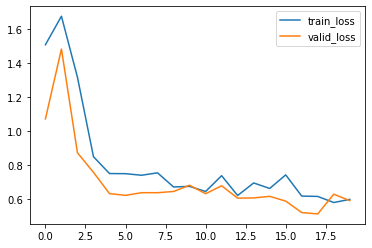

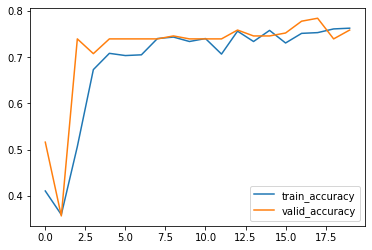

In [ ]:
plt.plot(hist.history['loss'], label='train_loss')
plt.plot(hist.history['val_loss'], label='valid_loss')
plt.legend()
plt.show()
plt.plot(hist.history['accuracy'], label='train_accuracy')
plt.plot(hist.history['val_accuracy'], label='valid_accuracy')
plt.legend()
plt.show()

In [ ]:
model.save('/content/model2.h5')

In [ ]:
model = tf.keras.models.load_model('/content/drive/My Drive/best_model15.h5')

In [ ]:
model.evaluate(X, y)

25/25 [==============================] - 45s 2s/step - loss: 0.0040 - precision_1: 0.9443 - recall_1: 0.9664 - accuracy: 0.9983


[0.00404011644423008,
 0.9443245530128479,
 0.9663853049278259,
 0.9983441829681396]

In [ ]:
model = tf.keras.models.load_model('/content/drive/My Drive/classific_model.h5')

In [ ]:
model.evaluate(X, y)

17/17 [==============================] - 3s 197ms/step - loss: 0.1300 - accuracy: 0.9693


[0.12995052337646484, 0.969348669052124]

### Создание генератора для тестовой выборки

In [ ]:
masks = tf.keras.models.load_model('/content/drive/My Drive/best_model15.h5')
classific = tf.keras.models.load_model('/content/drive/My Drive/classific_model_99.h5')

In [ ]:
X_gen = ImageDataGenerator(rescale = 1/255) \
  .flow_from_directory(directory = '/content/drive/My Drive/test',
    class_mode='binary',
    color_mode = 'grayscale',
    batch_size = 107,
    target_size=(H, W),
    shuffle = False)

Found 107 images belonging to 1 classes.


In [ ]:
X = X_gen.next()[0][..., 0]
for i, item in enumerate(X):
    X[i] = StandardScaler().fit_transform(item)
X = X[:, :, :, None]

In [ ]:
answers_masks = masks.predict(X)

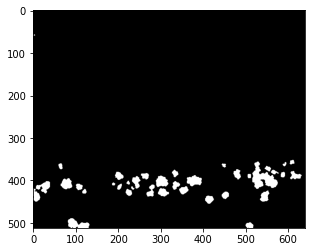

In [ ]:
_ = plt.imshow(answers_masks[1,...,0]>0.5, cmap = 'gray')

In [ ]:
answers_classes = classific.predict(X)

In [ ]:
names = np.sort(os.listdir('/content/drive/My Drive/train_classific'))
names

array(['c_kefir', 'ent_cloacae', 'klebsiella_pneumoniae',
       'moraxella_catarrhalis', 'staphylococcus_aureus',
       'staphylococcus_epidermidis'], dtype='<U26')

In [ ]:
picters = os.listdir('/content/drive/My Drive/test/test/')
picters = np.sort(picters)
picters[:5]

array(['001.png', '002.png', '003.png', '004.png', '005.png'], dtype='<U7')

In [ ]:
for ind, img in enumerate(answers_masks):
    img = (img>0.5)+0
    tf.keras.preprocessing.image.save_img(path='/content/drive/My Drive/test_mask/'+picters[ind],
                                      x=img, data_format='channels_last',file_format = 'PNG', scale = True)

In [ ]:
data = pd.DataFrame()
data

""


In [ ]:
data['id'] = picters
data['id'] = data['id'].apply(lambda x:x[:3])
data

,id
0,001
1,002
2,003
3,004
4,005
...,...
102,103
103,104
104,105
105,106


In [ ]:
classes = []
for i in answers_classes:
  classes += [names[i.argmax()]]
classes

['staphylococcus_epidermidis',
 'staphylococcus_epidermidis',
 'ent_cloacae',
 'ent_cloacae',
 'ent_cloacae',
 'ent_cloacae',
 'ent_cloacae',
 'klebsiella_pneumoniae',
 'klebsiella_pneumoniae',
 'klebsiella_pneumoniae',
 'klebsiella_pneumoniae',
 'klebsiella_pneumoniae',
 'klebsiella_pneumoniae',
 'staphylococcus_aureus',
 'moraxella_catarrhalis',
 'staphylococcus_aureus',
 'staphylococcus_epidermidis',
 'staphylococcus_aureus',
 'staphylococcus_aureus',
 'staphylococcus_aureus',
 'staphylococcus_aureus',
 'staphylococcus_epidermidis',
 'staphylococcus_epidermidis',
 'staphylococcus_epidermidis',
 'staphylococcus_epidermidis',
 'staphylococcus_epidermidis',
 'staphylococcus_epidermidis',
 'staphylococcus_aureus',
 'staphylococcus_epidermidis',
 'moraxella_catarrhalis',
 'moraxella_catarrhalis',
 'moraxella_catarrhalis',
 'moraxella_catarrhalis',
 'moraxella_catarrhalis',
 'klebsiella_pneumoniae',
 'moraxella_catarrhalis',
 'moraxella_catarrhalis',
 'moraxella_catarrhalis',
 'staphyloco

In [ ]:
data['class'] = classes
data

,id,class
0,001,staphylococcus_epidermidis
1,002,staphylococcus_epidermidis
2,003,ent_cloacae
3,004,ent_cloacae
4,005,ent_cloacae
...,...,...
102,103,ent_cloacae
103,104,ent_cloacae
104,105,ent_cloacae
105,106,ent_cloacae


In [ ]:
b64 = []
for i in picters:
    with open('/content/drive/My Drive/test_mask/'+i, 'rb') as picter:
        b64 += [base64.b64encode(picter.read()).decode('utf-8')]
data['base64 encoded PNG (mask)'] = b64
data.head()

,class,base64 encoded PNG (mask)
id,,
001,staphylococcus_epidermidis,iVBORw0KGgoAAAANSUhEUgAAAoAAAAIACAAAAAA3FoInAA...
002,staphylococcus_epidermidis,iVBORw0KGgoAAAANSUhEUgAAAoAAAAIACAAAAAA3FoInAA...
003,ent_cloacae,iVBORw0KGgoAAAANSUhEUgAAAoAAAAIACAAAAAA3FoInAA...
004,ent_cloacae,iVBORw0KGgoAAAANSUhEUgAAAoAAAAIACAAAAAA3FoInAA...
005,ent_cloacae,iVBORw0KGgoAAAANSUhEUgAAAoAAAAIACAAAAAA3FoInAA...


In [ ]:
data = data.set_index('id')

In [ ]:
data.to_csv('/content/drive/My Drive/ITS_answer.csv')